In [1]:
import numpy as np
import pandas as pd

from datetime import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans

import wrangle as wr
import preprocessing as pr
import explore as ex
import model as mo

import warnings
warnings.filterwarnings("ignore")


Bad key "text.kerning_factor" on line 4 in
/usr/local/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
pd.set_option("display.max_columns", None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
plt.rc("figure", figsize=(16, 8))
palette = sns.color_palette("colorblind")

In [3]:
df = wr.wrangle_hud()
print(df.shape)
df.head()

(20409, 31)


,fha_number,project_name,project_city,project_state,basic_fha_risk_share_or_other,program_category,activity_description,activity_group,facility_type,program_designation,firm_commitment_activity,lender_at_firm_commitment_activity,mortgage_at_time_of_firm_commitment_issuance_amendment_or_reissuance,unit_or_bed_count,date_of_firm_commitment_activity,fiscal_year_of_firm_commitment_activity,mortgage_at_firm_commitment_issuance,date_of_firm_issue,fiscal_year_of_firm_commitment,map_or_tap,lihtc_designation,tax_exempt_bond_designation,home_designation,cdbg_designation,section_202_refi_designation,irp_decoupling_designation,hope_vi_designation,current_status,final_mortgage_amount,is_refinance,is_new_construction
0,11345004,Western Heights Apartments,Olney,TX,Basic FHA,223a7 Refi Apts,Refinance,Refi/ Pchse,Apts,a7/236,Firm Issued,GREYSTONE SERVICING COMPANY LLC,277600,48,2005-10-01,2006,277600,2005-10-01,2006,TAP,False,False,False,False,False,False,False,Firm Comit then Owner Withdrew,271700,True,False
1,11345005,Woodlands Village Apts,Breckenridge,TX,Basic FHA,223a7 Refi Apts,Refinance,Refi/ Pchse,Apts,a7/236,Firm Issued,GREYSTONE SERVICING COMPANY LLC,173000,88,2005-10-01,2006,173000,2005-10-01,2006,TAP,False,False,False,False,False,False,False,Finally Endorsed,168300,True,False
2,4235583,Harbor Court Apartments,Rocky River,OH,Basic FHA,223a7 Refi Apts,Refinance,Refi/ Pchse,Apts,a7/221d4,Firm Issued,GREYSTONE SERVICING COMPANY LLC,3886800,120,2005-10-03,2006,3886800,2005-10-03,2006,TAP,False,False,False,False,False,False,False,Finally Endorsed,3886800,True,False
3,3297260,Compton Towne Apartments,Wilmington,DE,Risk Sharing,QPE Risk Sharing,Refinance,Refi/ Pchse,Coop/Apts/Mobile Home Pk/ALF,QPE Risk Shg Existing,Firm Issued,FEDERAL NATIONAL MORTGAGE,4000000,76,2005-10-03,2006,4000000,2005-10-03,2006,TAP,True,False,False,False,False,False,False,Finally Endorsed,4000000,True,False
4,7135779,Evergreen Terrace I,Joliet,IL,Basic FHA,223a7 Refi Apts,Refinance,Refi/ Pchse,Apts,a7/221d4,Firm Issued,REILLY MORTGAGE GRP,5129000,241,2005-10-04,2006,5129000,2005-10-04,2006,TAP,False,False,False,False,False,False,False,Firm Expired,5247700,True,False


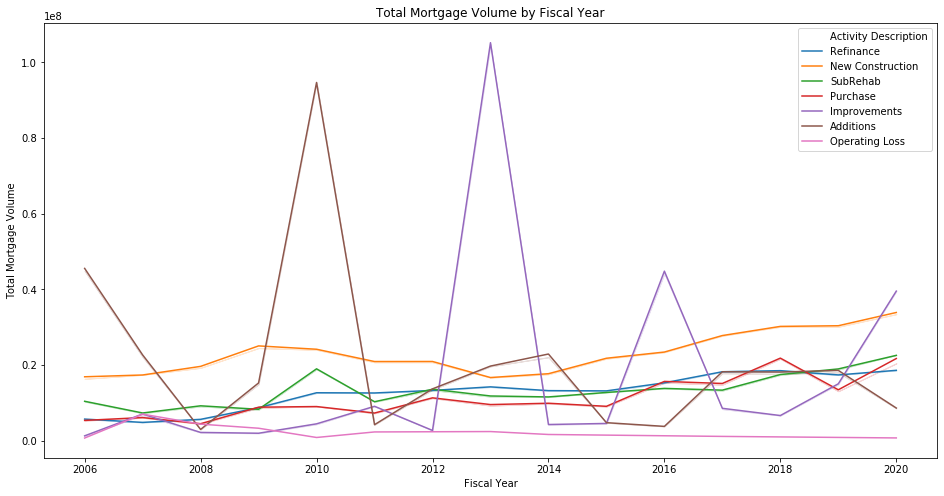

In [4]:
city_state_all_activity = pd.DataFrame(
    df.groupby(
        [
            "project_city",
            "project_state",
            "fiscal_year_of_firm_commitment_activity",
            "activity_description",
        ]
    )["final_mortgage_amount"]
    .agg(["count", "sum"])
    .reset_index()
    .sort_values(by=["count", "sum"], ascending=False)
)

fig, ax = plt.subplots()

sns.lineplot(
    data=city_state_all_activity,
    x="fiscal_year_of_firm_commitment_activity",
    y="sum",
    hue="activity_description",
    ci=False,
    ax=ax,
)

legend = ax.legend()
legend.texts[0].set_text("Activity Description")

plt.xlabel("Fiscal Year")
plt.ylabel("Total Mortgage Volume")
plt.title("Total Mortgage Volume by Fiscal Year")
plt.show()

**Takeaway**: New Construction (NC) mortgages have been growing steadily since 2014. Overall, NC is consistently where most of the mortgage loan volume is being allocated. *If we can find cities that are spending a lot on NC, we can ID those as markets to enter.*

### Hypothesis Testing

$H_0$: The mean final mortgage amount is the same across all activity descriptions

$H_a$: The mean final mortgage amount is different depending on the activity description

In [5]:
df.activity_description.unique().tolist()

['Refinance',
 'SubRehab',
 'New Construction',
 'Purchase',
 'Additions',
 'Improvements',
 'Operating Loss']

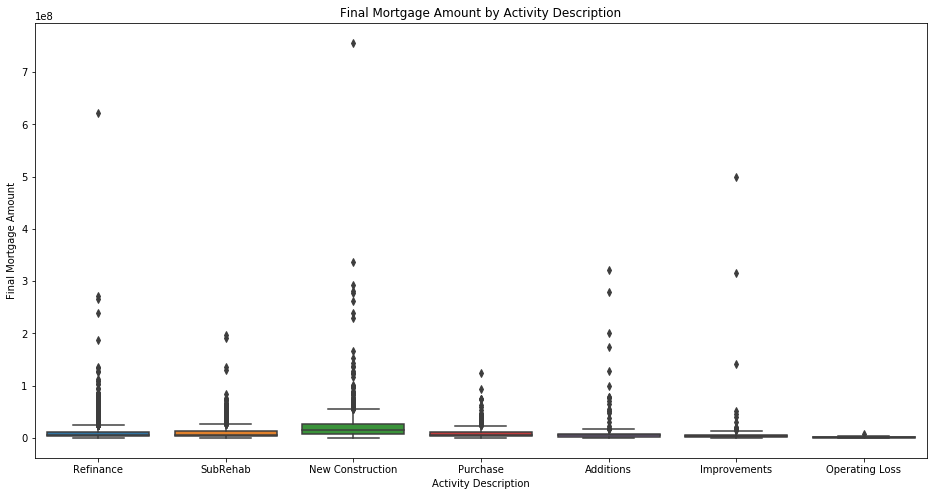

In [6]:
plt.figure(figsize=(16, 8))

sns.boxplot(data=df, x="activity_description", y="final_mortgage_amount")
plt.title("Final Mortgage Amount by Activity Description")
plt.xlabel("Activity Description")
plt.ylabel("Final Mortgage Amount")
plt.show()

In [7]:
# def plot_mortgage_vol_by_year():
#     city_state_all_activity = pd.DataFrame(
#         df.groupby(
#             [
#                 "project_city",
#                 "project_state",
#                 "fiscal_year_of_firm_commitment_activity",
#                 "activity_description",
#             ]
#         )["final_mortgage_amount"]
#         .agg(["count", "sum"])
#         .reset_index()
#         .sort_values(by=["count", "sum"], ascending=False)
#     )

#     fig, ax = plt.subplots()

#     sns.lineplot(
#         data=city_state_all_activity,
#         x="fiscal_year_of_firm_commitment_activity",
#         y="sum",
#         hue="activity_description",
#         ci=False,
#         ax=ax,
#     )

#     legend = ax.legend()
#     legend.texts[0].set_text("Activity Description")

#     plt.xlabel("Fiscal Year")
#     plt.ylabel("Total Mortgage Volume")
#     plt.title("Total Mortgage Volume by Fiscal Year")
#     plt.show()

In [8]:
# plot_mortgage_vol_by_year()

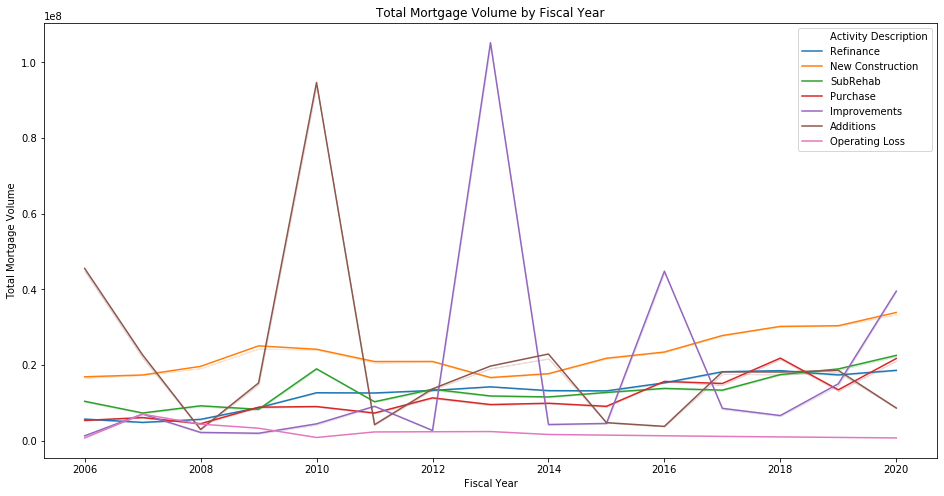

In [9]:
ex.plot_mortgage_vol_by_year(df)

## Preprocessing

In order to get our data into a useable format for modeling we decided to group the data by city and state for each fiscal year to get unique observations. Below is a brief summary of the functions found in the `preprocessing.py` script which help restructure the data into a useable format:

- `get_model_df`: This function wrangles the original data, groups the data using the city, state, and fiscal year features, and aggregates the mortgage data appropriately.
- `calculate_city_state_vol_delta`: This function creates the growth rate for each unique city + state + year observation using total mortgage volume.
- `calculate_city_state_qty_delta`: This function creates the growth rate for each unique city + state + year observation using the quantity of mortgages.
- `calculate_evolution_index`: This function calculates the evolution index using the market volume delta feature created within using the market volume feature. The evolution index is a measure which expresses the growth of a unique city + state + year observation relative to the the overall market growth rate for the whole year.
- `add_new_features`: This function calls `calculate_city_state_vol_delta`, `calculate_city_state_qty_delta`, and `calculate_evolution_index` to add new features to the modeling DataFrame.
- `train_validate_test_data`: This function slipts our data into train, validate, and test for modeling.
- `prep_data_for_modeling`: 

In [10]:
# def train_test_data(df):
#     train, test = train_test_split(df, train_size=.75, random_state=123, stratify = df["should_enter"])
#     return train, test

In [11]:
df = wr.wrangle_hud()

units = df.groupby(["project_city", "project_state", "fiscal_year_of_firm_commitment_activity"])[
        "unit_or_bed_count"
    ].agg(["sum", "mean", "median"]).sort_values(
        by=["sum"], ascending=False
    ).reset_index()

units.rename(
        columns={
            "project_city": "city",
            "project_state": "state",
            "fiscal_year_of_firm_commitment_activity": "year",
            "sum": "quantity_of_units",
            "mean": "average_number_of_units",
            "median": "median_number_of_units",
        },
        inplace=True,
    )

In [12]:
df.head()

,fha_number,project_name,project_city,project_state,basic_fha_risk_share_or_other,program_category,activity_description,activity_group,facility_type,program_designation,firm_commitment_activity,lender_at_firm_commitment_activity,mortgage_at_time_of_firm_commitment_issuance_amendment_or_reissuance,unit_or_bed_count,date_of_firm_commitment_activity,fiscal_year_of_firm_commitment_activity,mortgage_at_firm_commitment_issuance,date_of_firm_issue,fiscal_year_of_firm_commitment,map_or_tap,lihtc_designation,tax_exempt_bond_designation,home_designation,cdbg_designation,section_202_refi_designation,irp_decoupling_designation,hope_vi_designation,current_status,final_mortgage_amount,is_refinance,is_new_construction
0,11345004,Western Heights Apartments,Olney,TX,Basic FHA,223a7 Refi Apts,Refinance,Refi/ Pchse,Apts,a7/236,Firm Issued,GREYSTONE SERVICING COMPANY LLC,277600,48,2005-10-01,2006,277600,2005-10-01,2006,TAP,False,False,False,False,False,False,False,Firm Comit then Owner Withdrew,271700,True,False
1,11345005,Woodlands Village Apts,Breckenridge,TX,Basic FHA,223a7 Refi Apts,Refinance,Refi/ Pchse,Apts,a7/236,Firm Issued,GREYSTONE SERVICING COMPANY LLC,173000,88,2005-10-01,2006,173000,2005-10-01,2006,TAP,False,False,False,False,False,False,False,Finally Endorsed,168300,True,False
2,4235583,Harbor Court Apartments,Rocky River,OH,Basic FHA,223a7 Refi Apts,Refinance,Refi/ Pchse,Apts,a7/221d4,Firm Issued,GREYSTONE SERVICING COMPANY LLC,3886800,120,2005-10-03,2006,3886800,2005-10-03,2006,TAP,False,False,False,False,False,False,False,Finally Endorsed,3886800,True,False
3,3297260,Compton Towne Apartments,Wilmington,DE,Risk Sharing,QPE Risk Sharing,Refinance,Refi/ Pchse,Coop/Apts/Mobile Home Pk/ALF,QPE Risk Shg Existing,Firm Issued,FEDERAL NATIONAL MORTGAGE,4000000,76,2005-10-03,2006,4000000,2005-10-03,2006,TAP,True,False,False,False,False,False,False,Finally Endorsed,4000000,True,False
4,7135779,Evergreen Terrace I,Joliet,IL,Basic FHA,223a7 Refi Apts,Refinance,Refi/ Pchse,Apts,a7/221d4,Firm Issued,REILLY MORTGAGE GRP,5129000,241,2005-10-04,2006,5129000,2005-10-04,2006,TAP,False,False,False,False,False,False,False,Firm Expired,5247700,True,False


In [13]:
df = pr.get_model_df()
df = pr.add_new_features(df)
df = pr.filter_top_cities(df)

df = pd.merge(
    df,
    units,
    on=["city", "state", "year"],
    how="left"
)

print(f"""The train DataFrame contains {df.shape[0]} observations and {df.shape[1]} features.""")
df.head()

The train DataFrame contains 390 observations and 23 features.


,city,state,year,quantity_of_mortgages_pop,total_mortgage_volume_pop,average_mortgage_volume_pop,median_mortgage_amount_pop,quantity_of_mortgages_nc,total_mortgage_volume_nc,average_mortgage_volume_nc,median_mortgage_amount_nc,label,city_state_vol_delta_pop,city_state_vol_delta_nc,city_state_qty_delta_pop,city_state_qty_delta_nc,market_volume,market_volume_delta,ei,city_state,quantity_of_units,average_number_of_units,median_number_of_units
0,Atlanta,GA,2006,6,33186800,5531133.33333,4457100.00000,2.00000,9181100.00000,4590550.00000,4590550.00000,False,nan,nan,nan,nan,6774129256,nan,nan,Atlanta_GA,792,132.00000,99.50000
1,Atlanta,GA,2007,8,28277600,3534700.00000,3031150.00000,2.00000,4541700.00000,2270850.00000,2270850.00000,False,-0.14793,-0.50532,0.33333,0.00000,4973263164,-0.26584,1.16062,Atlanta_GA,1139,142.37500,152.50000
2,Atlanta,GA,2008,2,6735000,3367500.00000,3367500.00000,1.00000,4950000.00000,4950000.00000,4950000.00000,False,-0.76183,0.08990,-0.75000,-0.50000,4444102426,-0.10640,0.26653,Atlanta_GA,201,100.50000,100.50000
3,Atlanta,GA,2009,9,49972900,5552544.44444,4400000.00000,1.00000,3750000.00000,3750000.00000,3750000.00000,False,6.41988,-0.24242,3.50000,0.00000,7882704846,0.77375,4.18317,Atlanta_GA,1310,145.55556,136.00000
4,Atlanta,GA,2010,11,68788385,6253489.54545,5196100.00000,2.00000,7203500.00000,3601750.00000,3601750.00000,False,0.37651,0.92093,0.22222,1.00000,16193901958,1.05436,0.67005,Atlanta_GA,1774,161.27273,172.00000


In [14]:
df = pr.labeling_future_data(df)
train, validate, test = pr.split_data(df, train_size=.75,random_state = 124)

In [15]:
print(f"""The train DataFrame contains {train.shape[0]} observations and {train.shape[1]} features.""")
print(f"""The validate DataFrame contains {validate.shape[0]} observations and {validate.shape[1]} features.""")
print(f"""The test DataFrame contains {test.shape[0]} observations and {test.shape[1]} features.""")
train.head()

The train DataFrame contains 219 observations and 26 features.
The validate DataFrame contains 73 observations and 26 features.
The test DataFrame contains 98 observations and 26 features.


,city,state,year,quantity_of_mortgages_pop,total_mortgage_volume_pop,average_mortgage_volume_pop,median_mortgage_amount_pop,quantity_of_mortgages_nc,total_mortgage_volume_nc,average_mortgage_volume_nc,median_mortgage_amount_nc,label,city_state_vol_delta_pop,city_state_vol_delta_nc,city_state_qty_delta_pop,city_state_qty_delta_nc,market_volume,market_volume_delta,ei,city_state,quantity_of_units,average_number_of_units,median_number_of_units,label_quantity_of_mortgages_pop_2y,label_total_mortgage_volume_pop_2y,should_enter
144,Houston,TX,2015,6,80643200,13440533.33333,12803800.00000,1.00000,26555500.00000,26555500.00000,26555500.00000,False,0.43312,-0.13522,1.00000,0.00000,13569931547,-0.17285,1.73260,Houston_TX,1144,190.66667,185.00000,-0.55556,-0.48938,False
11,Atlanta,GA,2017,7,172278600,24611228.57143,12817700.00000,2.00000,86499900.00000,43249950.00000,43249950.00000,False,5.23297,7.35748,0.75000,1.00000,21015474899,0.34535,4.63298,Atlanta_GA,1483,211.85714,208.00000,-0.50000,-0.63726,False
168,Los Angeles,CA,2009,2,57056500,28528250.00000,28528250.00000,nan,nan,nan,nan,False,5.28064,0.00000,1.00000,0.00000,7882704846,0.77375,3.54089,Los Angeles_CA,414,207.00000,207.00000,0.00000,0.57268,False
320,San Francisco,CA,2011,6,173590400,28931733.33333,25912150.00000,1.00000,70000000.00000,70000000.00000,70000000.00000,False,3.67705,nan,0.50000,nan,17502078323,0.08078,4.32746,San Francisco_CA,982,163.66667,114.50000,4.00000,26.70772,True
40,Baltimore,MD,2016,13,196173700,15090284.61538,11000000.00000,2.00000,62047200.00000,31023600.00000,31023600.00000,False,0.54714,0.02889,0.08333,0.00000,15620858461,0.15114,1.34401,Baltimore_MD,2352,180.92308,151.00000,-0.50000,-0.65520,False


### Hypothesis Testing

$H_0$: The mean final mortgage amount is the same regardless of class

$H_a$: The mean final mortgage amount is different depending on class

In [16]:
alpha = .01

enter = train[train.should_enter == True].total_mortgage_volume_pop
dont_enter = train[train.should_enter == False].total_mortgage_volume_pop

tstat, pvalue = stats.ttest_ind(enter, dont_enter)

ex.get_stat_test_results(tstat, pvalue, alpha)

statistic = 2.31794
  p-value = 0.02138

Fail to reject null hypothesis


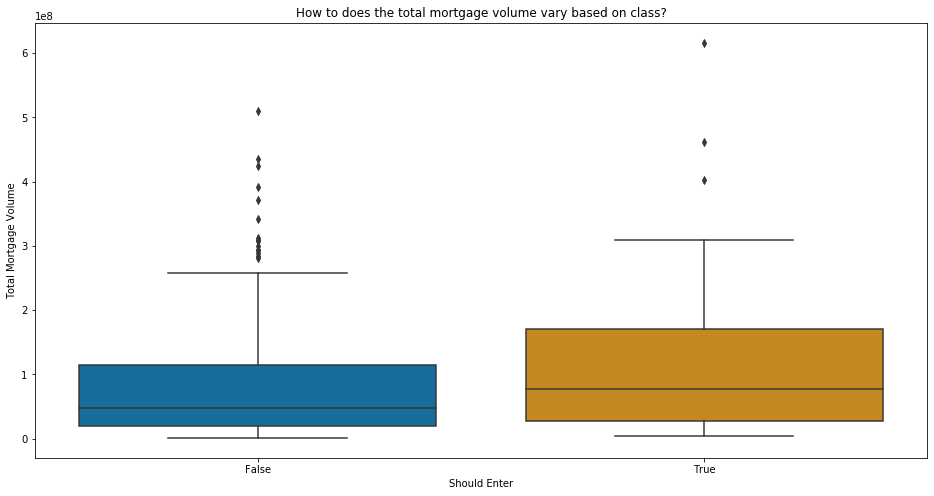

In [17]:
sns.boxplot(data=df, x="should_enter", y="total_mortgage_volume_pop", palette=palette)
plt.title("How to does the total mortgage volume vary based on class?")
plt.xlabel("Should Enter")
plt.ylabel("Total Mortgage Volume")
plt.show()

**Takeaways**: Here we can visualize how similar the two classes are. The mean total mortgage volume for these two classes is below $100M. Perhaps the main difference between the two classes is the interquartile range. 

### Hypothesis Testing

$H_0$: The mean quantity of units is the same regardless of class

$H_a$: The mmean quantity of units is different depending on class

In [18]:
alpha = .01

enter = train[train.should_enter == True].quantity_of_units
dont_enter = train[train.should_enter == False].quantity_of_units

tstat, pvalue = stats.ttest_ind(enter, dont_enter)

ex.get_stat_test_results(tstat, pvalue, alpha)

statistic = 1.51815
  p-value = 0.13043

Fail to reject null hypothesis


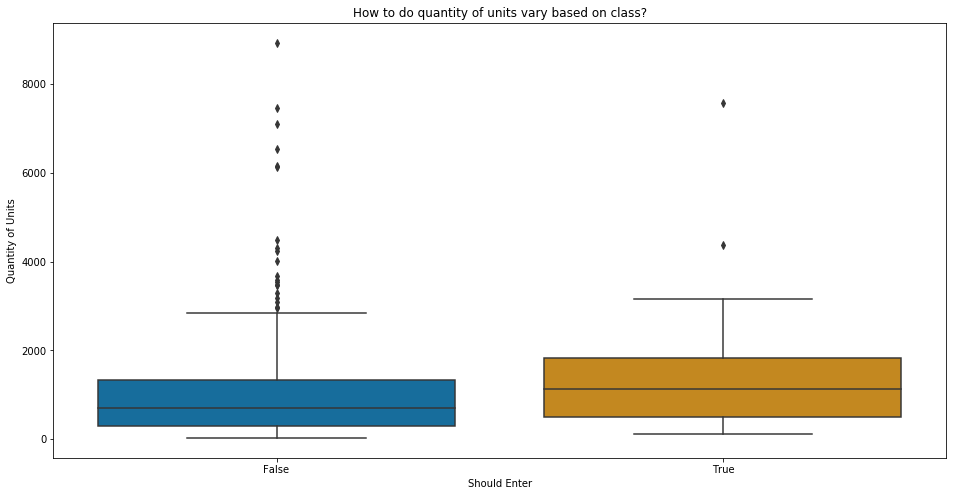

In [19]:
sns.boxplot(data=df, x="should_enter", y="quantity_of_units", palette=palette)
plt.title("How to do quantity of units vary based on class?")
plt.xlabel("Should Enter")
plt.ylabel("Quantity of Units")
plt.show()